**Author**: J W Debelius<br/>
**Date**: 17 August 2015<br/>
**virtualenv**: power play

In [1]:
%%javascript
IPython.load_extensions('calico-spell-check', 'calico-document-tools')

<IPython.core.display.Javascript object>

# Number of iterations

The purpose of this notebook is to simulate the number of iterations required to collapase power onto a central limit theorm by varying two parameters, `num_runs` and `num_iter`. The `num_iter` refers to the number of tests performed, and then combined to calculate the power. The `num_runs` determines how many of these emperical power values are averaged for the effect size calculation.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skbio
import scipy
import skbio

import absloute_power.utils as ap

from matplotlib import rcParams
from skbio.stats.power import subsample_power
from statsmodels.stats.power import FTestAnovaPower
ft = FTestAnovaPower()

We'll also set it up so that anything that is plotted here is plotted using Helvetica.

In [3]:
# Sets up plotting parameters so that the default setting is use to Helvetica
# in plots
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
rcParams['text.usetex'] = True


We'll start by simulating a pair of distributions which we can test with a two-sample t test.

In [4]:
# Defines the test
def practice_test(samples):
    return scipy.stats.ttest_ind(samples[0], samples[1])[1]

# Defines the sample
sample1 = np.random.randn(1000) * 3 + 2
sample2 = np.random.randn(1000) * 3 + 1

# Tests the over all distributions
practice_test([sample1, sample2])

5.3432389006337828e-09

Let's vary the number of samples that we iterate over, between 10 and 5000 tests per iteration. We'll do 100 runs, and use that to calculate the power.

In [5]:
num_iter = [10, 50, 100, 500, 1000, 5000]
num_runs = 100
power = []

for ni in num_iter:
    power.append(
        subsample_power(practice_test,
                        [sample1, sample2],
                        min_counts=10,
                        max_counts=40,
                        counts_interval=10,
                        num_runs=num_runs,
                        num_iter=ni)
    )
    print ni

10
50
100
500
1000
5000


Now, let's convert the power to effect size, using statsmodels. This is what we typically use when the data is underpowered.

In [6]:
effs = []
for (pwr, cnt) in power:
    eff = np.nan * np.ones((pwr.shape))
    for i, r in enumerate(pwr):
        for j, c in enumerate(cnt):
            try:
                eff[i,j] = ft.solve_power(effect_size=None, nobs=c, alpha=0.05, power=r[j])
            except:
                pass
    effs.append(eff)

Finally, we're going to put together a set of plots. We'll define a set of helper functions to let us manipulate the effect size results, and then to plot them.

In [20]:
color1 = np.array([0.45, 0.45, 0.45])
def all_e(eff):
    """Gets all the effect size values"""
    flat = eff.flatten()
    return flat[np.isnan(flat) == False]

def calc_e(eff, num_draws=3, runs=25):
    """..."""
    flat = np.array([
        np.nanmean(np.random.choice(eff.flatten(), num_draws))
        for i in xrange(runs)
        ])
    return flat[np.isnan(flat) == False]

def plot_e(ax, eff, counts, pwr_alpha=0.05, color=color1, opac=0.1):
    ax.plot(counts,
            ft.solve_power(eff, counts, alpha=pwr_alpha), 
            '-',
            color=color,
            alpha=opac)

def plot_mean(ax, eff, counts):
    ax.plot(counts, ft.solve_power(np.nanmean(eff), counts, 0.05), 'r-')

We'll also define parameters for plotting the data. We'll plot 100 iterations for each set, with values betwen 2 and 100. The critical value is 0.05. We'll combined data for 1, 3, 5, 10, and 25 sets of runs.

In [21]:
counts = np.hstack((np.array([2]),
                    np.arange(5, 101, 5)))
runs = 100
alpha = 0.05
fs=10

num_draws = [(1, all_e), 
             (3, lambda x: calc_e(x, 3, runs)),
             (5, lambda x: calc_e(x, 5, runs)),
             (10, lambda x: calc_e(x, 10, runs)),
             (25, lambda x: calc_e(x, 25, runs)),
            ]

Finally, we'll plot the data.

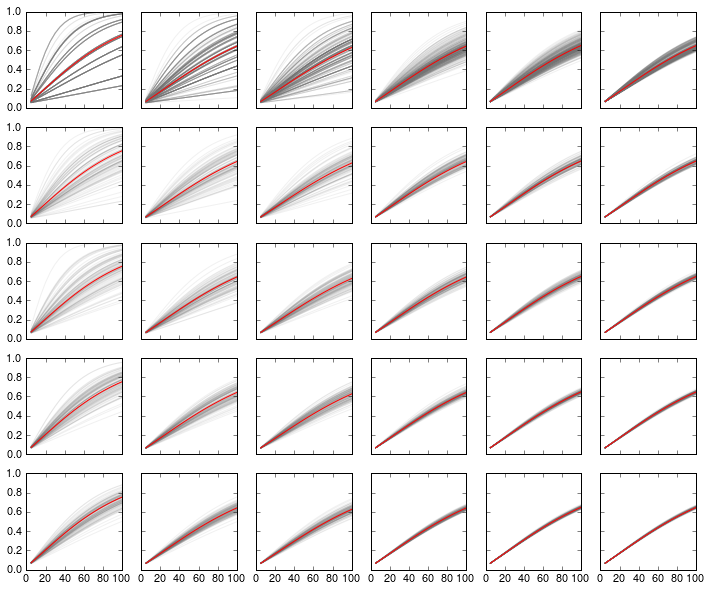

In [22]:
fig1 = plt.figure()
fig1.set_size_inches((12, 10))

for idy, eff in enumerate(effs):
    for idx, (num_draw, f_) in enumerate(num_draws):
        
        fn = '/Users/jwdebelius/Desktop/power_figs/iter/images/%i_runs_%i_iter.pdf' % (num_draw, num_iter[idy])
        
        ef2 = f_(eff)
        # Creates the summary figure for the notebook
        ax1 = fig1.add_subplot(5, 6, idx * 6 + idy + 1)
        for e in ef2:
            plot_e(ax1, e, counts, alpha, opac=0.1)
        plot_mean(ax1, eff, counts)
        # Cleans up the axis
        ap.format_ax(ax1,
                     xlim=[0, 100], 
                     ylim=[0, 1], 
                     show_x=(idx==4),
                     show_y=(idy==0),
                     xticks=np.arange(0, 101, 20),
                     )
        
        # Creates the individual figures for latex
        fig2 = plt.figure()
        fig2.set_size_inches(2.5/0.95, 2.5/0.95)
        ax2 = fig2.add_axes((0.05, 0.05, 0.9, 0.9))
        for e in ef2:
            plot_e(ax2, e, counts, alpha, opac=0.1)
        plot_mean(ax2, eff, counts)
        ap.format_ax(ax2,
                     fig=fig2,
                     xlim=[0, 100], 
                     ylim=[0, 1], 
                     show_x=(idx==4),
                     show_y=(idy==0),
                     xticks=np.arange(0, 101, 20),
                     fontsize1=20
                     )
        fig2.savefig(fn)
        plt.close(fig2)

The data starts to collapse with 1000 samples at 5 points, or 500 iterations at 10 points. So, 5000 seems like the magic number of iterations with this data.